## New simulation setup

We assume that neither lender knows the fraction of H-type borrowers in the population, or how the signals are generated. They simply employ some learning algorithm, based on the utility of some action, and learn the best strategy.

The market consists of a fraction $\theta$ of H-type borrowers, and $1-\theta$ of L-type borrowers. There are two lenders, 1 and 2, and each of them will receive a signal from each borrower. We let $p_{s_1, s_2}^{t}$ denote the probability that a borrower of true type $t\in \{L, H\}$ will give a signal of $s_1$ to lender 1, and $s_2$ to lender $s_1$, where $s_1,s_2\in \{l, h\}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

### Constants

Market size $N$, fraction of H-type borrower $\theta$, and probabilities of signal generation.

$$
P^H = \left[\begin{array}{cc}
p_{HH}^H, p_{HL}^H\\
p_{LH}^H, p_{LL}^H
\end{array}\right]
$$

$$
P^L = \left[\begin{array}{cc}
p_{HH}^L, p_{HL}^L\\
p_{LH}^L, p_{LL}^L
\end{array}\right]
$$

In [2]:
N = 10_000
Theta = 0.9
Borrower_types = ['H', 'L']
Signals = ['hh', 'hl', 'lh', 'll']
PH = np.array([[0.90, 0.03], 
               [0.02, 0.05]])
PL = np.array([[0.10, 0.06],
               [0.04, 0.80]])
ph_1d, pl_1d = PH.reshape(-1), PL.reshape(-1)
assert(PH.sum() == 1); assert(PL.sum() == 1)

### Generating borrowers with true types

In [3]:
Borrowers = np.random.choice(Borrower_types, size=N, p=[Theta, 1-Theta])
np.unique(Borrowers, return_counts=True)

(array(['H', 'L'], dtype='<U1'), array([9012,  988]))

### Generating signals

In [4]:
def signal(true_type, PH, PL):
    if true_type == 'H':
        return np.random.choice(Signals, p=PH)
    elif true_type == 'L':
        return np.random.choice(Signals, p=PL)
    else:
        raise ValueError

In [5]:
signals = [signal(b, ph_1d, pl_1d) for b in Borrowers]

In [6]:
lender1_signals = [s[0] for s in signals]
lender2_signals = [s[1] for s in signals]

In [7]:
np.unique(lender1_signals, return_counts=True), np.unique(lender2_signals, return_counts=True)

((array(['h', 'l'], dtype='<U1'), array([8572, 1428])),
 (array(['h', 'l'], dtype='<U1'), array([8462, 1538])))

### Wrapper

In [8]:
def gen_signals_for_one_round(N_borrowers, Theta, ph_1d, pl_1d):
    borrowers = np.random.choice(Borrower_types, size=N_borrowers, p=[Theta, 1-Theta])
    signals = [signal(b, ph_1d, pl_1d) for b in borrowers]
    lender1_signals = [s[0] for s in signals]
    lender2_signals = [s[1] for s in signals]
    return borrowers, lender1_signals, lender2_signals

In [9]:
# br, l1, l2 = gen_signals_for_one_round()

In [10]:
# np.unique(br, return_counts=True), np.unique(l1, return_counts=True), np.unique(l2, return_counts=True)

In [11]:
# print('Lender 1 expected number of h signals', N*Theta*PH[0].sum() + N*(1-Theta)*PL[0].sum())
# print('Lender 2 expected number of h signals', N*Theta*PH[:,0].sum() + N*(1-Theta)*PL[:,0].sum())

## Competition

I am assuming that after each round, we give both agents the exact utility they would have got if they had offered all l-signal/h-signal borrowers some interest rate $r'$. 

Both players keep track of the cumulative utility, and play follow the perturbed leader.

In [12]:
rs = np.linspace(0, 0.2, 11)
# we assume the 0 interest rate is refusal
rs

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ])

In [13]:
l1_cum_util = {
    'h': np.zeros_like(rs),
    'l': np.zeros_like(rs)
}
l2_cum_util = {
    'h': np.zeros_like(rs),
    'l': np.zeros_like(rs)
}

### Simulatin one round

both lenders make offers, then we calculate the utility on both sides

In [35]:
def make_offer_ftpl(cum_util, rs, normal_param = 0.8):
    n_choices = len(rs)
    perturbed_cum_util = cum_util + np.random.normal(0, normal_param, size=n_choices)
    return rs[np.argmax(perturbed_cum_util)]

def make_offer_naive(signal, rs, normal_param = 0.8):
    if signal == 'h':
        return np.random.default_rng().choice(rs)
    else:
        return 0

### Calculate the full utility given the opponent's offers

In [81]:
def update_cum_util(
    cum_util,
    lender_signal,
    opponent_offer,
    br,
    rs=rs,
):
    lender_signal = np.array(lender_signal)
    opponent_offer = np.array(opponent_offer)
    br = np.array(br)
    
    for r in rs:
        if r == 0:
            continue
        
        h_mask = lender_signal == 'h'
        l_mask = lender_signal == 'l'
        
        h_borrowers = br[h_mask]
        l_borrowers = br[l_mask]
        
        h_opponent_offers = opponent_offer[h_mask]
        l_opponent_offers = opponent_offer[l_mask]
        
        h_util = np.where((r < h_opponent_offers) | (h_opponent_offers == 0), np.where(h_borrowers == 'H', r, -1), 0)
        l_util = np.where((r < l_opponent_offers) | (l_opponent_offers == 0), np.where(l_borrowers == 'H', r, -1), 0)
        
        cum_h_util = np.sum(h_util)
        cum_l_util = np.sum(l_util)
        
        cum_h_count = np.sum(h_mask)
        cum_l_count = np.sum(l_mask)
        
        if cum_h_count > 0:
            cum_util['h'][np.where(rs == r)] += cum_h_util / cum_h_count
        if cum_l_count > 0:
            cum_util['l'][np.where(rs == r)] += cum_l_util / cum_l_count
    
    return cum_util

### Wrapping up

In [20]:
# reset things hers
N_rounds = 100
rs = np.linspace(0, 0.2, 11)
l1_cum_util = {
    'h': np.zeros_like(rs),
    'l': np.zeros_like(rs)
}
l2_cum_util = {
    'h': np.zeros_like(rs),
    'l': np.zeros_like(rs)
}

## Run for different settings

In [65]:
phs = [
    np.array([[1, 0.0], 
            [0.0, 0.0]]),
    np.array([[0.70, 0.23], 
            [0.02, 0.05]]),
    np.array([[0.70, 0.23], 
            [0.02, 0.05]]),
    np.array([[0.70, 0.23], 
            [0.02, 0.05]]),
    
]
pls = [
    np.array([[0.05, 0.02],
            [0.23, 0.70]]),
    np.array([[0.05, 0.02],
            [0.23, 0.70]]),
    np.array([[0.05, 0.02],
            [0.23, 0.70]]),
    np.array([[0.05, 0.02],
            [0.23, 0.70]])
]
Thetas = [0.9, 0.9, 0.99, 0.99]
# Thetas = [0.95, 0.97, 0.99]

In [66]:
def get_max_density(data1, data2, bins=rs):
    # Calculate densities for both datasets
    hist1, _ = np.histogram(data1, bins=bins, density=True)
    hist2, _ = np.histogram(data2, bins=bins, density=True)
    
    # Find the maximum density value
    return max(hist1.max(), hist2.max())

In [79]:
def compute_round_util(l1_offers, l2_offers, br):
    l1_utility = 0
    l2_utility = 0

    for br_id in range(len(br)):
        r1 = l1_offers[br_id]
        r2 = l2_offers[br_id]
        b = br[br_id] # borrower true type

        u1, u2 = 0, 0

        if (r1 < r2) or (r2 == 0):
            u1 = r1 if b == 'H' else -1
        if (r1 > r2) or (r1 == 0):
            u1 = r2 if b == 'H' else -1

        if r1 == r2:
            if r1 == 0:
                u1, u2 = 0, 0
            else:
                u1, u2 = r1 / 2, r2 / 2 if b == 'H' else -0.5

        l1_utility += u1
        l2_utility += u2

    return l1_utility, l2_utility

100%|██████████| 200/200 [00:58<00:00,  3.42it/s]


344.63000000000693 41.9400000000001


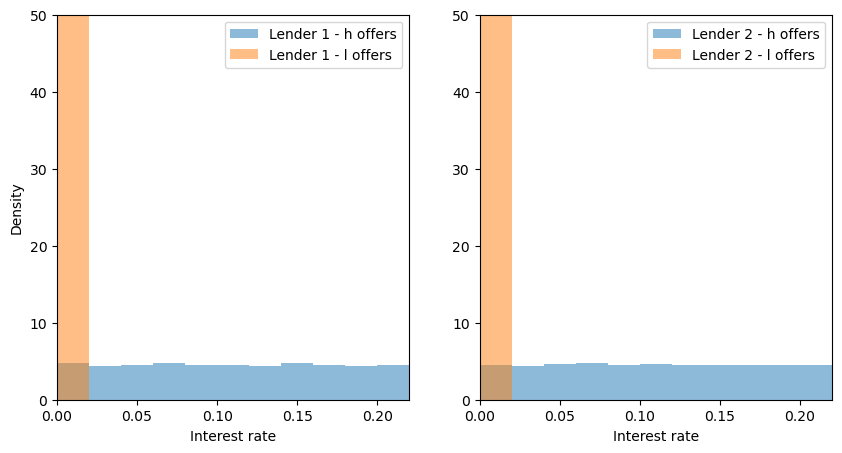

100%|██████████| 200/200 [00:49<00:00,  4.03it/s]

167.54000000000158 27.699999999999953


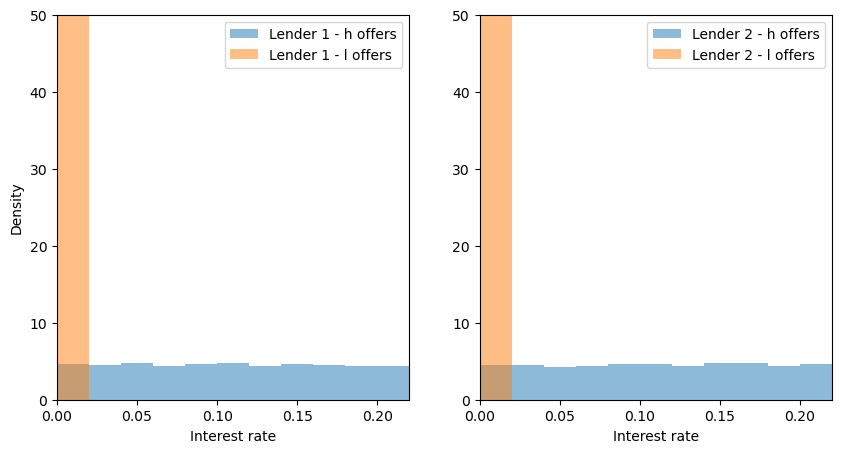

100%|██████████| 200/200 [00:51<00:00,  3.86it/s]

459.8900000000054 32.01000000000003


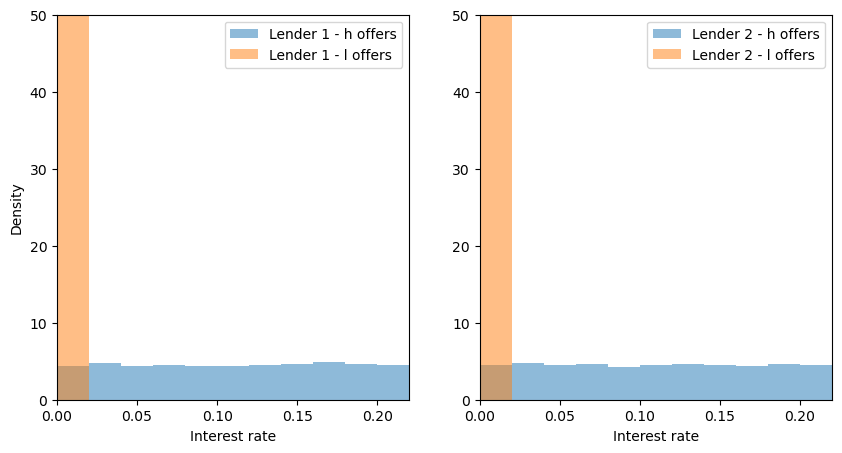

100%|██████████| 200/200 [00:50<00:00,  3.94it/s]


469.930000000006 31.889999999999986


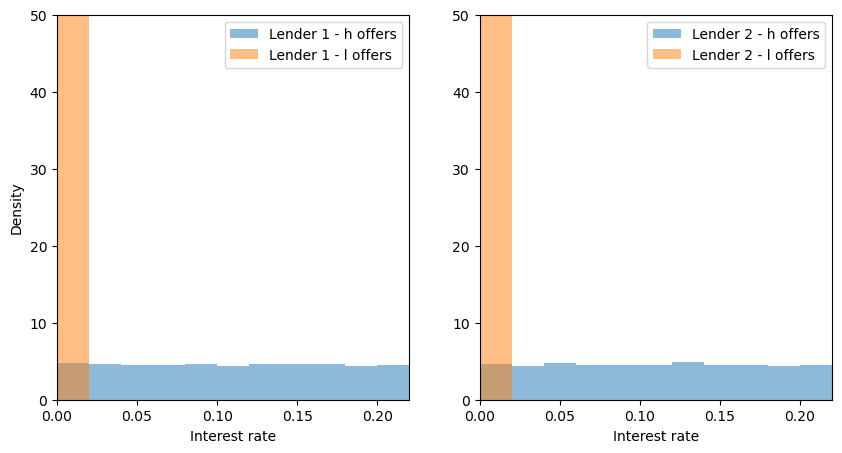

In [86]:
setting = ("naive_naive")

for PH, PL, Theta in zip(phs, pls, Thetas):   
        N = 10000
        Borrower_types = ['H', 'L']
        Signals = ['hh', 'hl', 'lh', 'll']
        ph_1d, pl_1d = PH.reshape(-1), PL.reshape(-1)
        assert(PH.sum() == 1); assert(PL.sum() == 1)

        # reset things hers
        N_rounds = 200
        rs = np.linspace(0, 0.2, 11)
        l1_cum_util = {
            'h': np.zeros_like(rs),
            'l': np.zeros_like(rs)
        }
        l2_cum_util = {
            'h': np.zeros_like(rs),
            'l': np.zeros_like(rs)
        }

        br, l1, l2 = gen_signals_for_one_round(N_borrowers=N, Theta=Theta, ph_1d=ph_1d, pl_1d=pl_1d)

        for round in tqdm(range(N_rounds)):
            l1_offers = []
            l2_offers = []
            # print out the cum utils
            # print(l1_cum_util, '\n', l2_cum_util)

            l1_offers = np.zeros(N)
            l2_offers = np.zeros(N)

            for br_id in range(N):
                l1_offers[br_id] = make_offer_naive(
                    l1[br_id], rs
                )
                # l1_offers[br_id] = make_offer_ftpl(
                #     l1_cum_util[l1[br_id]], rs
                # )
                l2_offers[br_id] = make_offer_naive(
                    l2[br_id], rs
                )
                # l2_offers[br_id] = make_offer_ftpl(
                #     l1_cum_util[l1[br_id]], rs
                # )

            l1_cum_util = update_cum_util(l1_cum_util, l1, l2_offers, br)
            l2_cum_util = update_cum_util(l2_cum_util, l2, l1_offers, br)

            l1_round_util, l2_round_util = compute_round_util(l1_offers, l2_offers, br)

        l1_h_index = np.where(np.array(l1) == 'h')
        l1_l_index = np.where(np.array(l1) == 'l')
        l2_h_index = np.where(np.array(l2) == 'h')
        l2_l_index = np.where(np.array(l2) == 'l')

        bins = np.append(rs, 0.22)

        print(l1_round_util, l2_round_util)

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        # plot lender 1 in the first plot
        ax[0].hist(np.array(l1_offers)[l1_h_index], bins=bins, alpha=0.5, label='Lender 1 - h offers', density=True)
        ax[0].hist(np.array(l1_offers)[l1_l_index], bins=bins, alpha=0.5, label='Lender 1 - l offers', density=True)
        ax[0].set_xlim(0, 0.22)
        max_density = get_max_density(np.array(l1_offers)[l1_h_index], np.array(l1_offers)[l1_l_index], bins = rs)
        ax[0].set_ylim(0, max_density)
        ax[0].legend()

        # plot lender 2 in the second plot
        ax[1].hist(np.array(l2_offers)[l2_h_index], bins=bins, alpha=0.5, label='Lender 2 - h offers', density=True)
        ax[1].hist(np.array(l2_offers)[l2_l_index], bins=bins, alpha=0.5, label='Lender 2 - l offers', density=True)
        ax[1].set_xlim(0, 0.22)
        max_density = get_max_density(np.array(l2_offers)[l2_h_index], np.array(l2_offers)[l2_l_index])
        ax[1].set_ylim(0, max_density)
        ax[1].legend()

        # ylabel
        ax[0].set_ylabel('Density')
        
        # xlabel
        ax[0].set_xlabel('Interest rate')
        ax[1].set_xlabel('Interest rate')

        plt.savefig(f'plots/lender_offers_' + setting + '_{ph_1d}_{pl_1d}_{Theta}.png')
        plt.show()

        plt.close()